<link rel="stylesheet" href="https://gist.github.com/vietjtnguyen/6643431/raw/9e88999ef07c40ee4af6be9cb3e0c9e618ba64a3/custom.css" type="text/css"/>

<style>
@import url(http://fonts.googleapis.com/css?family=Droid+Sans+Mono);

h1, h2, h3, h4, h5, h6 {
    font-family: "STIX-Bold", serif;
}
p, ol, ul {
    font-family: "STIX-Regular", serif;
    font-size: 115%;
}
ul ul, li, ul li, li li {
    font-family: "STIX-Regular", serif;
    font-size: 100%;
}
b {
    font-family: "STIX-Bold", serif;
    font-size: 115%;
}
i {
    font-family: "STIX-Italic", serif;
    font-size: 115%;
}
code, pre, div.input_prompt, div.output_area pre {
    font-family: "Droid Sans Mono", "Courier New", monospace;
}
.CodeMirror pre {
    font-family: "Droid Sans Mono", "Courier New", monospace;
}

/*
@import url(http://fonts.googleapis.com/css?family=Source+Code+Pro);
.CodeMirror pre {
    font-family: "cmu_typewriter_textregular", monospace;
    font-size: 115%;
}
*/

span.MathJax {
    font-size: 86.956521739%;
}
</style>

# Fun with Logistic Regression

This notebook was derived from the [Caltech "Learning from Data" course](http://work.caltech.edu/telecourse.html), specifically [Lecture 9](http://www.youtube.com/watch?v=qSTHZvN8hzs&hd=1) on the logistic regression model. It is a simple Python implementation of the logistic regression model using [NumPy](http://numpy.scipy.org/).

## Table of Contents

* [Derivation](#Derivation)
  * [Error Measure](#ErrorMeasure)
  * [Learning Algorithm](#LearningAlgorithm)
* [Example](#Example)
  * [Data Set](#Data-Set)
  * [Learning a Hypothesis](#Learning-a-Hypothesis)
  * [Learning with Less Data](#Learning-with-Less-Data)
  * [Learning Curve](#Learning-Curve)
  * [Visualizing the Error Surface](#Visualizing-the-Error-Surface)
  * [Nonlinear Transformation](#Nonlinear-Transformation)

## Notation

The problem structure is the classic classification problem. Our data set $\mathcal{D}$ is composed of $N$ samples. Each sample is a tuple containing a feature vector and a label. For any sample $n$ the feature vector is a $d+1$ dimensional column vector denoted by ${\bf x}_n$ with $d$ real-valued components known as features. Samples are represented in homogeneous form with the first component equal to $1$: $x_0=1$. Vectors are bold-faced. The associated label is denoted $y_n$ and can take on only two values: $+1$ or $-1$.

$$
\mathcal{D} = \lbrace ({\bf x}_1, y_1), ({\bf x}_2, y_2), ..., ({\bf x}_N, y_N) \rbrace \\
{\bf x}_n = \begin{bmatrix} 1 & x_1 & ... & x_d \end{bmatrix}^T 
$$

# Derivation

Despite the name logistic *regression* this is actually a probabilistic classification model. It is also a linear model which can be subjected to nonlinear transforms.

All linear models make use of a "signal" $s$ which is a linear combination of the input vector ${\bf x}$ components weighed by the corresponding components in a weight vector ${\bf w}$.

$$
{\bf w} = \begin{bmatrix} w_0 & w_1 & ... & w_d \end{bmatrix}^T \\
s = w_0 + w_1 x_1 + \;...\; + w_d x_d = \sum_{i=0}^d w_i x_i = {\bf w} \cdot {\bf x} = {\bf w}^T {\bf x}
$$

Note that the homogeneous representation (with the $1$ at the first component) allows us to include a constant offset using a more compact vector-only notation (instead of ${\bf w}^T {\bf x}+b$).

Linear classification passes the signal through a harsh threshold:

$$
h({\bf x}) = \operatorname{sign}(s)
$$

Linear regression uses the signal directly without modification:

$$
h({\bf x}) = s
$$

Logistic regression passes the signal through the logistic/sigmoid but then treats the result as a probability:

$$
h({\bf x}) = \theta(s)
$$

The [logistic function](http://en.wikipedia.org/wiki/Logistic_function) is

$$
\theta(s) = \frac{e^s}{1+e^s} = \frac{1}{1+e^{-s}}
$$

There are many other formulas that can achieve a soft threshold such as the hyperbolic tangent, but this function results in some nice simplification.

We say that the data is generated by a noisy target.

$$
P(y\mid{\bf x})=\begin{cases}
f({\bf x}) & \text{for }y=+1 \\
1-f({\bf x}) & \text{for }y=-1
\end{cases}
$$

With this noisy target we want to learn a hypothesis $h({\bf x})$ that best fits the above noisy target according to some error function.

$$
h({\bf x})=\theta({\bf w}^T {\bf x})\approx f({\bf x})
$$

It's important to note that the data does not tell you the probability of a label but rather what label the sample has after being generated by the target distribution.

## Error Measure

To learn a good hypothesis we want to find a hypothesis parameterization ${\bf w}$ (the weight vector) that minimizes some in-sample error measure $E_\text{in}$.

$$
{\bf w}_h = \underset{{\bf w}}{\operatorname{argmin}} \; E_\text{in}({\bf w})
$$

The error measure we will use is both plausible and nice. It is based on likelihood which is the probability of generating the data given a model.

If our hypothesis is close to our target distribution ($h\approx f$) then we expect that probability of generating the data to be high.

There is some controversy with using likelihood. We are really looking for the most probable hypothesis given the data: $\underset{h}{\operatorname{argmax}} P(h\mid{\bf x})$. The likelihood approach is looking for the hypothesis that makes the data most probable: $\underset{h}{\operatorname{argmax}} P({\bf x}\mid h)$.

The Bayesian approach tackles this issue using [Bayes' Theorem](http://en.wikipedia.org/wiki/Bayes'_theorem) but introduces other issues such as choosing priors.

To determine the likelihood we assume the data was generated with our hypothesis $h$:

$$
P(y\mid{\bf x})=\begin{cases}
h({\bf x}) & \text{for }y=+1 \\
1-h({\bf x}) & \text{for }y=-1
\end{cases} \\
$$

where $h({\bf x})=\theta({\bf w}^T {\bf x})$.

We don't want to deal with cases so we take advantage of a nice property of the logistic function: $\theta(-s)=1-\theta(s)$.

$$
\text{if } y = +1 \text{ then } h({\bf x}) = \theta({\bf w}^T {\bf x}) = \theta(y \; {\bf w}^T {\bf x}) \\
\text{if } y = -1 \text{ then } 1 - h({\bf x}) = 1 - \theta({\bf w}^T {\bf x}) = \theta(- {\bf w}^T {\bf x}) = \theta(y \; {\bf w}^T {\bf x}) \\
$$

Using this simplification,

$$
P(y\mid{\bf x})=\theta(y\; {\bf w}^T {\bf x})
$$

The likelihood is defined for a data set $\mathcal{D}$ with $N$ samples given a hypothesis (denoted arbitrarily $g$ here):

$$
L(\mathcal{D} \mid g) =
\prod_{n=1}^{N} P(y_n \mid {\bf x}_n) =
\prod_{n=1}^{N} \theta(y_n \; {\bf w}_g^T {\bf x}_n)
$$

Now finding a good hypothesis is a matter of finding a hypothesis parameterization ${\bf w}$ that maximizes the likelihood.

$$
{\bf w}_h =
\underset{{\bf w}}{\operatorname{argmax}} \; L(\mathcal{D} \mid h) = 
\underset{{\bf w}}{\operatorname{argmax}} \; \theta(y_n \; {\bf w}^T {\bf x}_n)
$$

Maximizing the likelihood is equivalent to maximizing the log of the function since the natural logarithm is a monotonically increasing function:

$$
\underset{{\bf w}}{\operatorname{argmax}} \; \ln \left( \prod_{n=1}^{N} \theta(y_n \; {\bf w}^T {\bf x}_n) \right)
$$

We can maximize the above proportional to a constant as well so we'll tack on a $\frac{1}{N}$:

$$
\underset{{\bf w}}{\operatorname{argmax}} \; \frac{1}{N} \ln \left( \prod_{n=1}^{N} \theta(y_n \; {\bf w}^T {\bf x}_n) \right)
$$

Now maximizing that is the same as minimizing its negative:

$$
\underset{{\bf w}}{\operatorname{argmin}} \left[ -\frac{1}{N} \ln \left( \prod_{n=1}^{N} \theta(y_n \; {\bf w}^T {\bf x}_n) \right) \right]
$$

If we move the negative into the log and the log into the product we turn the product into a sum of logs:

$$
\underset{{\bf w}}{\operatorname{argmin}} \;\frac{1}{N} \sum_{n=1}^{N} \ln \left( \frac{1}{\theta(y_n \; {\bf w}^T {\bf x}_n)} \right)
$$

Expanding the logistic function,

$$
\underset{{\bf w}}{\operatorname{argmin}} \;\frac{1}{N} \sum_{n=1}^{N} \ln \left( 1 + e^{y_n \; {\bf w}^T {\bf x}_n} \right)
$$

Now we have a much nicer form for the error measure known as the "cross-entropy" error.

$$
E_\text{in}({\bf w}) = \frac{1}{N} \sum_{n=1}^{N} \ln \left( 1+e^{-y_n \; {\bf w}^T {\bf x}_n} \right)
$$

This is nice because it can be interpreted as the average point error where the point error function is

$$
e(h({\bf x}_n), y_n) = \ln \left( 1+e^{-y_n \; {\bf w}^T {\bf x}_n} \right) \\
E_\text{in}({\bf w}) = \frac{1}{N} \sum_{n=1}^{N} e(h({\bf x}_n), y_n)
$$

So to learn a hypothesis we'll want to perform the following optimization:

$$
{\bf w}_h =
\underset{{\bf w}}{\operatorname{argmin}} \; E_\text{in}({\bf w}) =
\underset{{\bf w}}{\operatorname{argmin}} \;\frac{1}{N} \sum_{n=1}^{N} \ln \left( 1 + e^{y_n \; {\bf w}^T {\bf x}_n} \right)
$$

## Learning Algorithm

The learning algorithm is how we search the set of possible hypotheses (hypothesis space $\mathcal{H}$) for the best parameterization (in this case the weight vector ${\bf w}$). This search is an optimization problem looking for the hypothesis that optimizes an error measure.

There is no nice, closed-form solution like with [least-squares linear regression](http://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_pseudoinverse) so we will use [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent) instead. Specifically we will use batch gradient descent which calculates the gradient from all data points in the data set.

Luckily, our "cross-entropy" error measure is [convex](http://en.wikipedia.org/wiki/Convex_optimization) so there is only one minimum. Thus the minimum we arrive at is the global minimum.

Gradient descent is a general method and requires twice differentiability for [smoothness](http://en.wikipedia.org/wiki/Smooth_function). It updates the parameters using a first-order approximation of the error surface.

$$
{\bf w}_{i+1} = {\bf w}_i + \nabla E_\text{in}({\bf w}_i)
$$

To learn we're going to minimize the following error measure using batch gradient descent.

$$
e(h({\bf x}_n), y_n) = \ln \left( 1+e^{-y_n \; {\bf w}^T {\bf x}_n} \right) \\
E_\text{in}({\bf w}) = \frac{1}{N} \sum_{n=1}^{N} e(h({\bf x}_n), y_n) = \frac{1}{N} \sum_{n=1}^{N} \ln \left( 1+e^{-y_n \; {\bf w}^T {\bf x}_n} \right)
$$

We'll need to the derivative of the point loss function and possibly some abuse of notation.

$$
\frac{d}{d{\bf w}} e(h({\bf x}_n), y_n)
= \frac{-y_n \; {\bf x}_n \; e^{-y_n {\bf w}^T {\bf x}_n}}{1 + e^{-y_n {\bf w}^T {\bf x}_n}}
= -\frac{y_n \; {\bf x}_n}{1 + e^{y_n {\bf w}^T {\bf x}_n}}
$$

With the point loss derivative we can determine the gradient of the in-sample error:

$$
\begin{align}
\nabla E_\text{in}({\bf w})
&= \frac{d}{d{\bf w}} \left[ \frac{1}{N} \sum_{n=1}^N e(h({\bf x}_n), y_n) \right] \\
&= \frac{1}{N} \sum_{n=1}^N \frac{d}{d{\bf w}} e(h({\bf x}_n), y_n) \\
&= \frac{1}{N} \sum_{n=1}^N \left( - \frac{y_n \; {\bf x}_n}{1 + e^{y_n {\bf w}^T {\bf x}_n}} \right) \\
&= - \frac{1}{N} \sum_{n=1}^N \frac{y_n \; {\bf x}_n}{1 + e^{y_n {\bf w}^T {\bf x}_n}} \\
\end{align}
$$

Our weight update rule per batch gradient descent becomes

$$
\begin{align}
{\bf w}_{i+1} &= {\bf w}_i - \eta \; \nabla E_\text{in}({\bf w}_i) \\
&= {\bf w}_i - \eta \; \left( - \frac{1}{N} \sum_{n=1}^N \frac{y_n \; {\bf x}_n}{1 + e^{y_n {\bf w}_i^T {\bf x}_n}} \right) \\
&= {\bf w}_i + \eta \; \left( \frac{1}{N} \sum_{n=1}^N \frac{y_n \; {\bf x}_n}{1 + e^{y_n {\bf w}_i^T {\bf x}_n}} \right) \\
\end{align}
$$

where $\eta$ is our learning rate.

# Example

First we'll get the dependencies out of the way.

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import itertools
import random
import time

For pretty visualization we'll define some custom [color maps](http://matplotlib.org/api/cm_api.html).

In [2]:
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),
         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
         'blue':  ((0.0, 1.0, 1.0),
                   (1.0, 0.0, 0.0))}
BinaryRdBu = matplotlib.colors.LinearSegmentedColormap('BinaryRdBu', cdict, 2)
cdict = {'red':   ((0.0, 0.9, 0.9),
                   (1.0, 1.0, 1.0)),
         'green': ((0.0, 0.9, 0.9),
                   (1.0, 0.9, 0.9)),
         'blue':  ((0.0, 1.0, 1.0),
                   (1.0, 0.9, 0.9))}
LightRdBu = matplotlib.colors.LinearSegmentedColormap('LightRdBu', cdict)
cdict = {'red':   ((0.0, 1.0, 1.0),
                   (0.4, 0.7, 0.7),
                   (0.5, 0.0, 0.0),
                   (0.6, 0.7, 0.7),
                   (1.0, 1.0, 1.0)),
         'green': ((0.0, 1.0, 1.0),
                   (0.4, 0.7, 0.7),
                   (0.5, 0.0, 0.0),
                   (0.6, 0.7, 0.7),
                   (1.0, 1.0, 1.0)),
         'blue':  ((0.0, 1.0, 1.0),
                   (0.4, 0.7, 0.7),
                   (0.5, 0.0, 0.0),
                   (0.6, 0.7, 0.7),
                   (1.0, 1.0, 1.0))}
HalfContour = matplotlib.colors.LinearSegmentedColormap('HalfContour', cdict)

We'll define our [logistic/sigmoid function](http://en.wikipedia.org/wiki/Logistic_function) using the latter definition since it uses only one exponentiation.

$$
\theta(s)=\frac{e^s}{1+e^s}=\frac{1}{1+e^{-s}}
$$

In [3]:
logistic = lambda s: 1.0 / (1.0 + np.exp(-s))

## Data Set

For this example we'll create a toy data set.

To visualize this properly we'll set the input dimension size to $d=2$. For now we'll keep it linear ($\phi({\bf x})={\bf x}$).

In [4]:
d_x = 2

phi = lambda x: x
d_z = len( phi( np.ones((d_x+1,)) ) ) - 1

For our data set we'll generate $N=100$ points.

In [5]:
N = 100

We'll define our input distribution $P({\bf x})$ to be uniform within the intervals $\left[-1, 1\right]$ for visualization purposes. Note the homogeneous representation with $x_0=1$.

In [6]:
P_x = lambda: np.array( [1.0] + [np.random.uniform(-1, 1) for i in range(d_x)] ) # simulates P(x)

Now we need to create a fake, linear, noisy target $P(y\mid{\bf x})$. The target distribution is parameterized by a "target function" $f$ which will be drawn randomly from our hypothesis set (linear logistic probability models). The weights are randomly chosen for good visual effect (thus the `hardness` measure).

In [7]:
def generate_target(d, hardness=20.0, offset_ratio=0.25, w_f=None):
    
    # randomize target weights
    if w_f is None:
        w_f = np.array([np.random.uniform(-hardness * offset_ratio, hardness * offset_ratio)] +
                       [np.random.uniform(-hardness, hardness) for i in range(d)])
    
    # create target distribution simulator
    f = lambda z: logistic(w_f.dot(z.T))
    P_f = lambda z: ( np.array([np.random.uniform() for i in range(z.shape[0])]) <= f(z) )*2.0-1.0
        # "*2.0-1.0" to scale from [0, 1] to [-1, 1] which are our actual label values
    
    return w_f, f, P_f

In [8]:
w_f, f, P_f = generate_target(d_z, hardness=12.0)

With our target distribution we can generate our toy data set. Note that $\mathcal{Z}$ is the same as $\mathcal{X}$ in this linear example.

In [9]:
def generate_data_samples(N, P_x, phi, P_f):
    
    # create samples in our input space (x-space)
    x = np.array([P_x() for i in range(N)])
    
    # transform x-space samples to z-space samples
    z = np.apply_along_axis(phi, 1, x)
    
    # produce classification labels from target distribution
    y = P_f(z)
    
    # create function to calculate cross-entropy error from a hypothesis weight vector
    cross_entropy_error = lambda w: np.mean(np.log(1 + np.exp(-y * w.dot(z.T))))
    
    return x, z, y, cross_entropy_error

In [10]:
x, z, y, cross_entropy_error = generate_data_samples(N, P_x, phi, P_f)

Now let's visualize our data set. For our pretty fills and contours we need to define the entire grid to some level of detail. Here we'll use $s=300$ meaning 300 points per axis.

In [11]:
def generate_fill_data(s=300, phi=lambda x: x):
    # create grid of points
    x_1, x_2 = np.array(np.meshgrid(np.linspace(-1, 1, s), np.linspace(-1, 1, s)))
    
    # reshape the grid to an array of homogenized points
    x_grid = np.hstack((np.ones((s*s, 1)), np.reshape(x_1, (s*s, 1)), np.reshape(x_2, (s*s, 1))))
    
    # transform homogenized points into z-space
    z_grid = np.apply_along_axis(phi, 1, x_grid)
    
    return x_1, x_2, x_grid, z_grid

In [12]:
def apply_to_fill(z_grid, func):
    s = int(np.sqrt(z_grid.shape[0]))
    
    # calculate function at each point on the grid and reshape it back to a grid
    return np.reshape(func(z_grid), (s, s))

In [13]:
x_1, x_2, x_grid, z_grid = generate_fill_data(300, phi)
f_grid = apply_to_fill(z_grid, f)

We'll plot our data set along with the background probability from the noisy target. Red points are classified as $+1$ and blue points are classified as $-1$. The background color denotes the probability of the data generating distribution. The black line is the decision boundary where the probability is equal to $0.5$.

In [14]:
def plot_data_set_and_hypothesis(x, y, x_1, x_2, f_grid=None, title=''):
    start_time = time.time()
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect(1)
    ax.set_xlabel(r'$x_1$', fontsize=18)
    ax.set_ylabel(r'$x_2$', fontsize=18)
    if not title == '':
        ax.set_title(title, fontsize=18)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.set_axisbelow(True)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.autoscale(False)
    
    if not f_grid is None:
        # plot background probability
        ax.pcolor(x_1, x_2, f_grid, cmap=LightRdBu, vmin=0, vmax=1)
        
        # plot decision boundary
        ax.contour(x_1, x_2, f_grid*2-1, cmap=HalfContour, levels=[-0.5, 0.0, 0.5], vmin=-1, vmax=1)
    
    # plot data set
    ax.scatter(x[:, 1], x[:, 2], s=40, c=y, cmap=BinaryRdBu, vmin=-1, vmax=1)
    
    print('Plot took {:.2f} seconds.'.format(time.time()-start_time))
    
    return fig

Plot took 5.81 seconds.


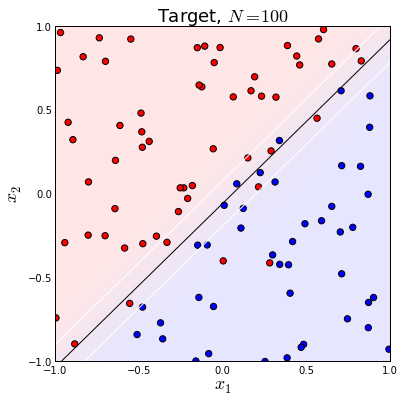

In [15]:
target_fig = plot_data_set_and_hypothesis(x, y, x_1, x_2, f_grid,
                                          title=r'Target, $N={:}$'.format(N))

## Learning a Hypothesis

Let's initialize our hypothesis parameters to zero and perform gradient descent with a learning rate of $\eta=10.0$. We'll continue iteration for a maximum of $\text{10,000}$ iterations or until the change in the weight vector's norm is smaller than $0.1\%$, which ever comes first. As a reminder, our update rule is

$$
{\bf w}_{i+1} = {\bf w}_i + \eta \; \left( \frac{1}{N} \sum_{n=1}^N \frac{y_n \; {\bf x}_n}{1 + e^{y_n {\bf w}_i^T {\bf x}_n}} \right)
$$

In [16]:
def gradient_descent(z, y, w_h=None, eta=1.0, max_iterations=10000, epsilon=0.001):
    if w_h == None:
        w_h = np.array([0.0 for i in range(z.shape[1])])
    
    # save a history of the weight vectors into an array
    w_h_i = [np.copy(w_h)]
    
    for i in range(max_iterations):
        subset_indices = range(z.shape[0])
        # subset_indices = np.random.permutation(z.shape[0])[:N/8] # uncomment for stochastic gradient descent
        
        grad_E_in = np.mean(np.tile(- y[subset_indices] /
                                        ( 1.0 + np.exp(y[subset_indices] * w_h.dot(z[subset_indices].T)) ),
                                    (z.shape[1], 1)).T * 
                            z[subset_indices], axis=0)
        
        w_h -= eta * grad_E_in
        w_h_i.append(np.copy(w_h))
        
        if np.linalg.norm(grad_E_in) <= np.linalg.norm(w_h) * epsilon:
            break
    
    return np.array(w_h_i)

In [17]:
w_h_i = gradient_descent(z, y, eta=4.0)
w_h = w_h_i[-1]
print('Number of iterations: {:}'.format(w_h_i.shape[0]))

Number of iterations: 73


Now we'll visualize the final hypothesis $g$ in the input space $\mathcal{X}$.

In [18]:
h = lambda z: logistic(w_h.dot(z.T))
h_grid = apply_to_fill(z_grid, h)

Plot took 5.42 seconds.


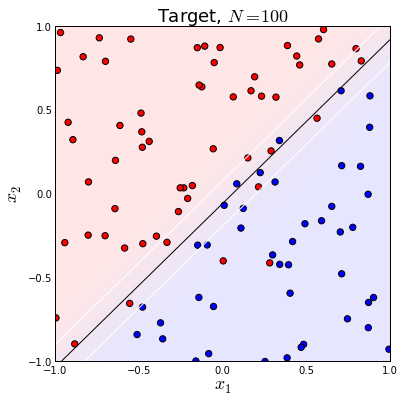

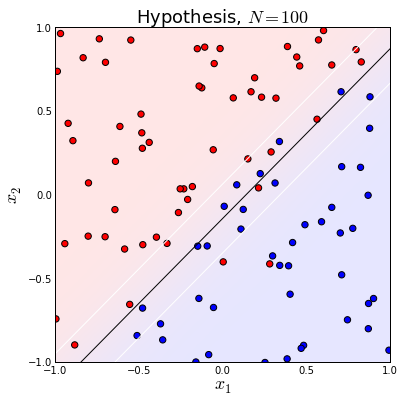

In [19]:
full_N_fig = plot_data_set_and_hypothesis(x, y, x_1, x_2, h_grid,
                                          title=r'Hypothesis, $N={:}$'.format(N))
target_fig.show()

Since we have the target distribution we can stochastically estimate the out-of-sample error. Classifying using the logistic regression is a matter of choosing the label that is most probable for a data point. So if the output of the hypothesis function $h$ is greater than $0.5$ we label the data point $y=+1$ and vice versa.

In [20]:
def in_sample_error(z, y, h):
    y_h = (h(z) >= 0.5)*2-1
    return np.sum(y != y_h) / float(len(y))

In [21]:
def estimate_out_of_sample_error(P_x, phi, P_f, h, N=10000, phi_h=None):
    x = np.array([P_x() for i in range(N)])
    z = np.apply_along_axis(phi, 1, x)
    if not phi_h is None:
        z_h = np.apply_along_axis(phi_h, 1, x)
    else:
        z_h = z
    y = P_f(z)
    y_h = (h(z_h) >= 0.5)*2-1
    return np.sum(y != y_h) / float(N)

Note the relatively high error rates for a toy data set due to treating the decision boundary as a hard threshold despite the noisy nature of the target distribution. The higher our `hardness` factor on our toy data set the smaller this error rate will be.

In [22]:
print('Target weights: {:}'.format(w_f))
print('Hypothesis weights: {:}'.format(w_h))
print('Hypothesis in-sample error: {:.2%}'.format(in_sample_error(z, y, h)))
print('Hypothesis out-of-sample error: {:.2%}'.format(estimate_out_of_sample_error(P_x, phi, P_f, h)))

Target weights: [ 0.41537607 -7.94492     8.11922518]
Hypothesis weights: [ 0.72043721 -5.41271258  5.34073738]
Hypothesis in-sample error: 8.00%
Hypothesis out-of-sample error: 8.89%


## Learning with Less Data

If we learn from a smaller set of data, say $N=10$, we should see a larger discrepancy in the out-of-sample error.

In [23]:
N_subset = 10
subset_indices = np.random.permutation(N)[:N_subset]
x_subset = x[subset_indices, :]
z_subset = z[subset_indices, :]
y_subset = y[subset_indices]

w_h_i_subset = gradient_descent(z_subset, y_subset, eta=10.0)
w_h_subset = w_h_i_subset[-1]
print('Number of iterations: {:}'.format(w_h_i_subset.shape[0]))

Number of iterations: 12


In [24]:
h_subset = lambda z: logistic(w_h_subset.dot(z.T))
h_subset_grid = apply_to_fill(z_grid, h_subset)

Plot took 5.42 seconds.


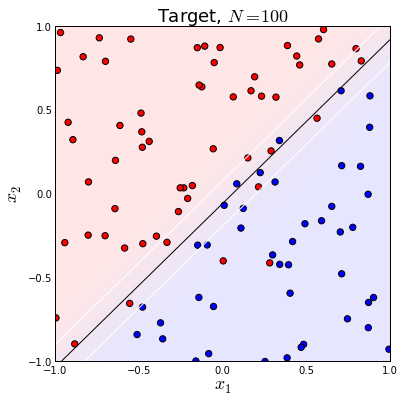

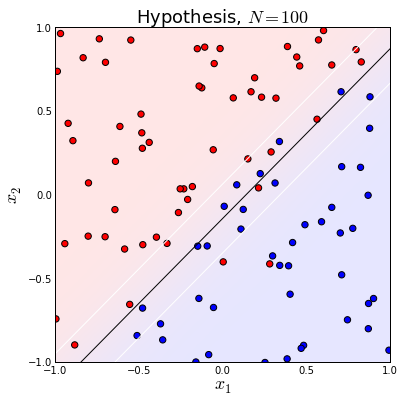

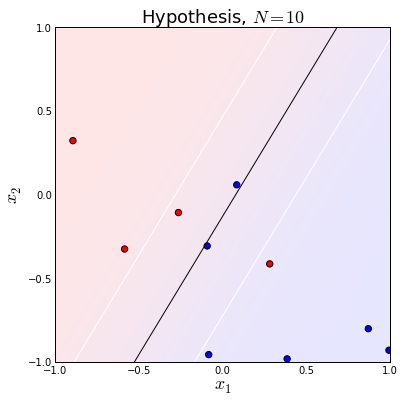

In [25]:
subset_N_fig = plot_data_set_and_hypothesis(x_subset, y_subset, x_1, x_2, h_subset_grid,
                                            title=r'Hypothesis, $N={:}$'.format(N_subset))
target_fig.show()
full_N_fig.show()

If the resulting hypothesis looks off we need to remember what the learning algorithm sees: just the data.

Plot took 0.06 seconds.


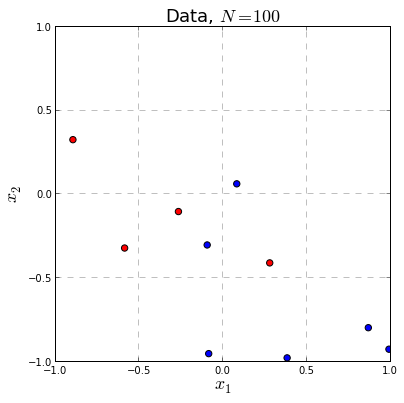

In [26]:
naked_fig = plot_data_set_and_hypothesis(x_subset, y_subset, x_1, x_2, None, title=r'Data, $N={:}$'.format(N))

With the metrics below we can see that the quality of the final hypothesis depends on the number of samples we have as predicted by learning theory.

In [27]:
print('Target weights: {:}'.format(w_f))
print('Target in-sample error: {:.2%}'.format(in_sample_error(z, y, f)))
print('Target out-of-sample error: {:.2%}'.format(estimate_out_of_sample_error(P_x, phi, P_f, f)))

Target weights: [ 0.41537607 -7.94492     8.11922518]
Target in-sample error: 7.00%
Target out-of-sample error: 7.85%


In [28]:
print('Hypothesis (N={:}) weights: {:}'.format(N, w_h))
print('Hypothesis (N={:}) in-sample error: {:.2%}'.format(N, in_sample_error(z, y, h)))
print('Hypothesis (N={:}) out-of-sample error: {:.2%}'.format(N, estimate_out_of_sample_error(P_x, phi, P_f, h)))

Hypothesis (N=100) weights: [ 0.72043721 -5.41271258  5.34073738]
Hypothesis (N=100) in-sample error: 8.00%
Hypothesis (N=100) out-of-sample error: 8.77%


In [29]:
print('Hypothesis (N={:}) weights: {:}'.format(N_subset, w_h_subset))
print('Hypothesis (N={:}) in-sample error: {:.2%}'.format(N_subset, in_sample_error(z_subset, y_subset, h_subset)))
print('Hypothesis (N={:}) out-of-sample error: {:.2%}'.format(N_subset, estimate_out_of_sample_error(P_x, phi, P_f, h_subset)))

Hypothesis (N=10) weights: [ 0.22155369 -3.05283829  1.84902211]
Hypothesis (N=10) in-sample error: 20.00%
Hypothesis (N=10) out-of-sample error: 12.71%


## Learning Curve

Since we can stochastically estimate the out-of-sample error we can plot approximate learning curves. The learning curve will show us how the in-sample error and out-of-sample error behave as the data resources improve.

Warning: this can take a while to evaluate.

In [30]:
start_time = time.time()

error_histories = []

for runs in range(10):
    N = 201
    x = np.array([P_x() for i in range(N)])
    z = np.apply_along_axis(phi, 1, x)
    y = P_f(z)
    
    error_history = []
    
    for N_subset in range(1, N+1, 4):
        x_subset = x[:N_subset, :]
        z_subset = z[:N_subset, :]
        y_subset = y[:N_subset]
        
        w_h = gradient_descent(z_subset, y_subset)[-1]
        h = lambda z: logistic(w_h.dot(z.T))
        
        error_history.append([N_subset,
                              in_sample_error(z_subset, y_subset, h),
                              estimate_out_of_sample_error(P_x, phi, P_f, h)])
    
    error_histories.append(error_history)

error_history = np.mean(np.array(error_histories), axis=0)

print('Error history took {:.2f} seconds.'.format(time.time()-start_time))

Error history took 121.16 seconds.


In [31]:
target_error = estimate_out_of_sample_error(P_x, phi, P_f, f, N=100000)

Plot took 0.06 seconds.


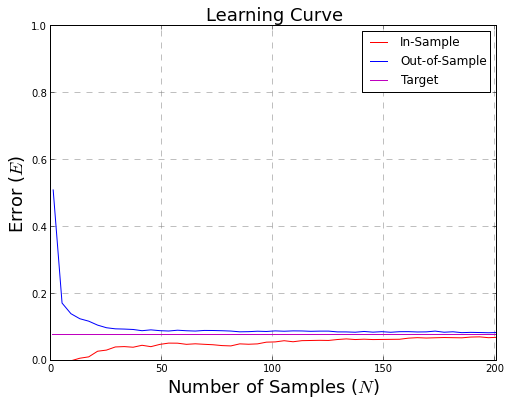

In [32]:
start_time = time.time()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel(r'Number of Samples ($N$)', fontsize=18)
ax.set_ylabel(r'Error ($E$)', fontsize=18)
ax.set_title(r'Learning Curve'.format(N), fontsize=18)
ax.set_xlim(0, error_history[-1, 0])
ax.set_ylim(0, 1)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.set_axisbelow(True)

ax.plot(error_history[:, 0], error_history[:, 1], 'r-', label='In-Sample')
ax.plot(error_history[:, 0], error_history[:, 2], 'b-', label='Out-of-Sample')
ax.plot(error_history[[0, -1], 0], [target_error]*2, 'm-', label='Target')
ax.legend()

print('Plot took {:.2f} seconds.'.format(time.time()-start_time))

## Visualizing the Error Surface

For curiosity sake, let's try and visualize the error surface. But before visualizing the surface let's look at how the error measure changes as the gradient descent proceeds.

In [33]:
def plot_gradient_descent(w_h_i, cross_entropy_error):
    start_time = time.time()
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(r'Iteration', fontsize=18)
    ax.set_ylabel(r'In-Sample Error ($E_{in}$)', fontsize=18)
    ax.set_title(r'Gradient Descent Evolution'.format(N), fontsize=18)
    ax.set_xlim(0, w_h_i.shape[0]-1)
    ax.set_ylim(0, 1)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.set_axisbelow(True)
    
    ax.plot(range(w_h_i.shape[0]), np.apply_along_axis(cross_entropy_error, 1, w_h_i), 'r-')
    
    print('Plot took {:.2f} seconds.'.format(time.time()-start_time))

Plot took 0.05 seconds.


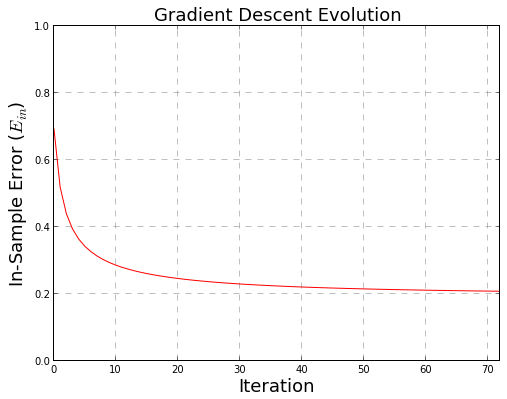

In [34]:
plot_gradient_descent(w_h_i, cross_entropy_error)

The in-sample error is parameterized by our model parameters ${\bf w}$. Unfortunately our parameter is of dimension $d_{\bf w}=3$ which makes visualization a bit more difficult (a four dimensional visualization problem: three parameters and an error value). Instead of tackling that directly (volumetrics and other fun stuff) we'll just visualize the top, front, and left slices of the error surface centered on the final hypothesis parameters. Along with these slices the iterations we've taken on the error surface using gradient descent which will be colored by iteration number backwards through a rainbow color map. Using the history of the weight vector through the gradient descent iterations we can determine the extents of our visualization.

In [35]:
def visualize_error_surface_slices(w_h_i, cross_entropy_error, s=150, figsize=(6, 6)):
    d_z = w_h_i.shape[1]
    
    w_h_i_mean = np.mean(w_h_i, axis=0)
    w_h_i_std = np.std(w_h_i, axis=0)
    w_h_i_min_extent = w_h_i_mean - 4 * np.max(w_h_i_std)
    w_h_i_max_extent = w_h_i_mean + 4 * np.max(w_h_i_std)
    w_h_i_colors = cm.ScalarMappable(norm=matplotlib.colors.Normalize(0, w_h_i.shape[0]-1),
                                     cmap=cm.gist_rainbow_r).to_rgba(range(w_h_i.shape[0]-1))
    
    for i_x, i_y in itertools.combinations(list(range(1, d_z)) + [0], 2):
    
        start_time = time.time()
        
        components = list(range(d_z))
        components.remove(i_x)
        components.remove(i_y)
        
        w_zs = [w_h[i] * np.ones((s*s, 1)) for i in components]
        w_x, w_y = np.array(np.meshgrid(np.linspace(w_h_i_min_extent[i_x], w_h_i_max_extent[i_x], s),
                                        np.linspace(w_h_i_min_extent[i_y], w_h_i_max_extent[i_y], s)))
        
        restack = [None] * (d_z)
        restack[i_x] = np.reshape(w_x, (s*s, 1))
        restack[i_y] = np.reshape(w_y, (s*s, 1))
        for i_z, w_z in zip(components, w_zs):
            restack[i_z] = w_z
        w_grid = np.hstack(restack)
        
        error_grid = np.reshape(np.apply_along_axis(cross_entropy_error, 1, w_grid), (s, s))
    
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
        ax.set_aspect(1)
        ax.set_xlabel(r'$w_{:}$'.format(i_x), fontsize=18)
        ax.set_ylabel(r'$w_{:}$'.format(i_y), fontsize=18)
        if d_z == 3:
            ax.set_title(r'Error Surface ({:} view)'.format({0: '"top-to-bottom"',
                                                             1: '"right-to-left"',
                                                             2: '"back-to-front"'}[components[0]]),
                         fontsize=18)
        else:
            ax.set_title(r'Error Surface', fontsize=18)
        ax.set_xlim(w_h_i_min_extent[i_x], w_h_i_max_extent[i_x])
        ax.set_ylim(w_h_i_min_extent[i_y], w_h_i_max_extent[i_y])
        ax.autoscale(False)
        
        ax.pcolor(w_x, w_y, error_grid, cmap=cm.gist_heat, vmin=np.min(error_grid), vmax=np.max(error_grid))
        
        ax.xaxis.grid(color='gray', linestyle='dashed')
        ax.yaxis.grid(color='gray', linestyle='dashed')
        
        for i in range(w_h_i.shape[0]-1):
            ax.plot(w_h_i[i:i+2, i_x], w_h_i[i:i+2, i_y], '-', c=w_h_i_colors[i])
        
        print('Plot took {:.2f} seconds.'.format(time.time()-start_time))

Plot took 2.43 seconds.
Plot took 2.50 seconds.
Plot took 2.37 seconds.


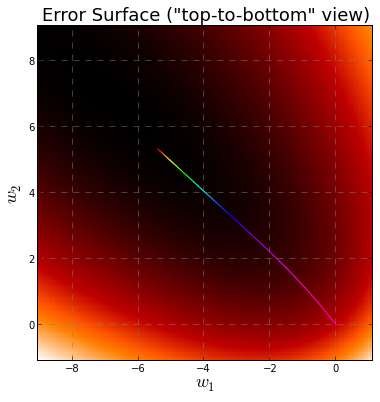

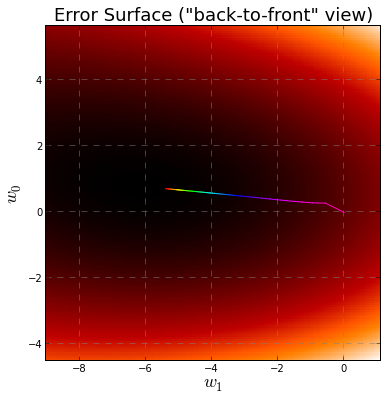

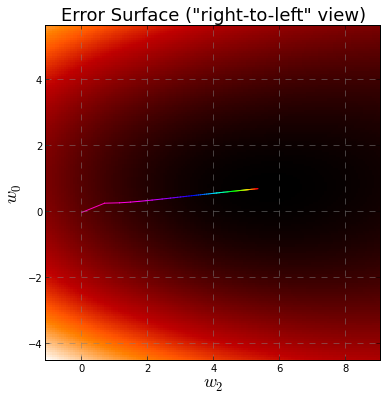

In [36]:
visualize_error_surface_slices(w_h_i, cross_entropy_error, s=150)

## Nonlinear Transformation

Like with the other linear models (perceptron, linear regression) we can transform the input data from the original input space ($\mathcal{X}$) into a higher dimension space ($\mathcal{Z}$) and fit our model there.

In this example we'll use a second-order polynomial transformation:

$$
\phi({\bf x}) = \begin{bmatrix} 1 & x_0 & x_1 & x_0 x_1 & x_0^2 & x_1^2 \end{bmatrix}
$$

In [37]:
d_x = 2

phi = lambda x: np.array([1, x[1], x[2], x[1]*x[2], x[1]**2, x[2]**2])
d_z = len( phi( np.ones((d_x+1,)) ) ) - 1

N = 30

Plot took 5.23 seconds.


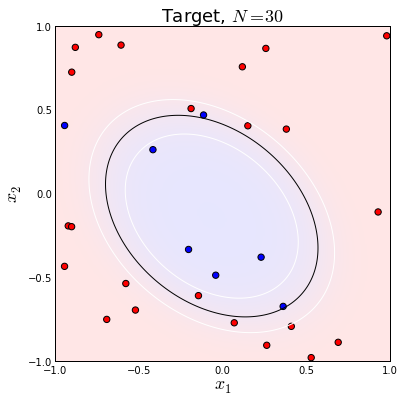

In [38]:
w_f, f, P_f = generate_target(d_z, w_f=np.array([-3, 2, 3, 6, 9, 10]))
x, z, y, cross_entropy_error = generate_data_samples(N, P_x, phi, P_f)
x_1, x_2, x_grid, z_grid = generate_fill_data(300, phi)
f_grid = apply_to_fill(z_grid, f)
target_fig = plot_data_set_and_hypothesis(x, y, x_1, x_2, f_grid, title=r'Target, $N={:}$'.format(N))

In [39]:
w_h_i = gradient_descent(z, y, eta=4.0)
w_h = w_h_i[-1]
print('Number of iterations: {:}'.format(w_h_i.shape[0]))

Number of iterations: 143


Plot took 5.35 seconds.


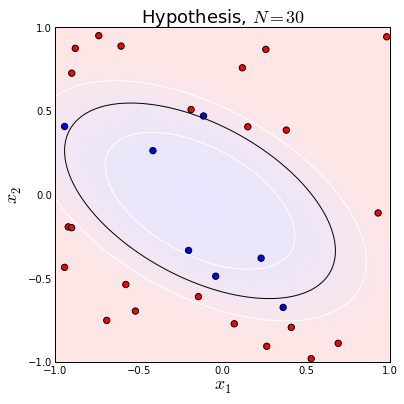

In [40]:
h = lambda z: logistic(w_h.dot(z.T))
h_grid = apply_to_fill(z_grid, h)
hypothesis_fig = plot_data_set_and_hypothesis(x, y, x_1, x_2, h_grid, title=r'Hypothesis, $N={:}$'.format(N))

In [41]:
print('Target weights: {:}'.format(w_f))
print('Hypothesis weights: {:}'.format(w_h))
print('Hypothesis in-sample error: {:.2%}'.format(in_sample_error(z, y, h)))
print('Hypothesis out-of-sample error: {:.2%}'.format(estimate_out_of_sample_error(P_x, phi, P_f, h)))

Target weights: [-3  2  3  6  9 10]
Hypothesis weights: [-2.03435116  1.43625398  1.42565611  6.32051478  4.462231    8.56118427]
Hypothesis in-sample error: 10.00%
Hypothesis out-of-sample error: 14.87%


For fun we'll try visualizing the error surface again. However, since we're operating in the $\mathcal{Z}$ space with dimension $d_\mathcal{Z}=6$ our two-dimensional visualizations are even more woefully inadequate. Regardless, below is the gradient descent evolution and all 15 combinations of two axes and their two-dimensional error "surface" slice centered on the hypothesis weight vector.

Plot took 0.05 seconds.


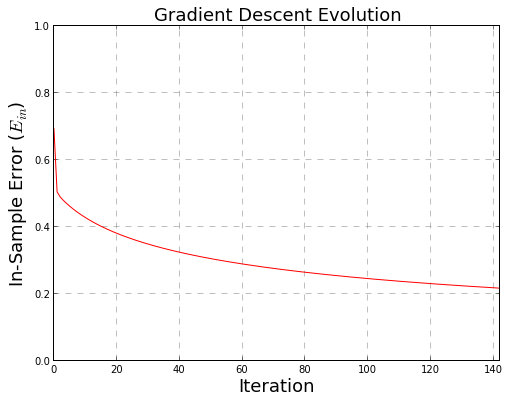

In [42]:
plot_gradient_descent(w_h_i, cross_entropy_error)

Plot took 2.31 seconds.
Plot took 2.48 seconds.
Plot took 2.35 seconds.
Plot took 2.31 seconds.
Plot took 2.44 seconds.
Plot took 2.30 seconds.
Plot took 2.43 seconds.
Plot took 2.31 seconds.
Plot took 2.29 seconds.
Plot took 2.45 seconds.
Plot took 2.29 seconds.
Plot took 2.29 seconds.
Plot took 2.29 seconds.
Plot took 2.48 seconds.
Plot took 2.30 seconds.


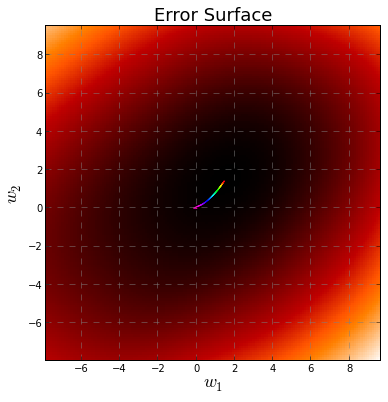

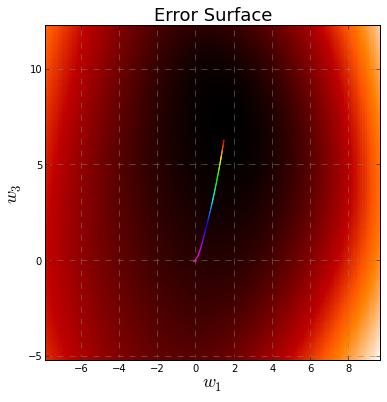

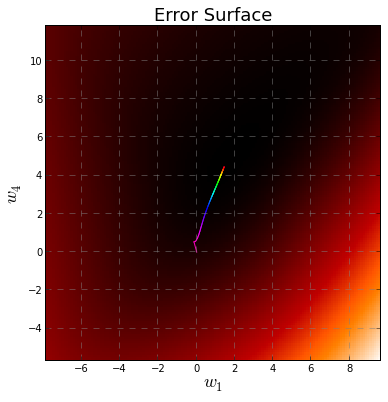

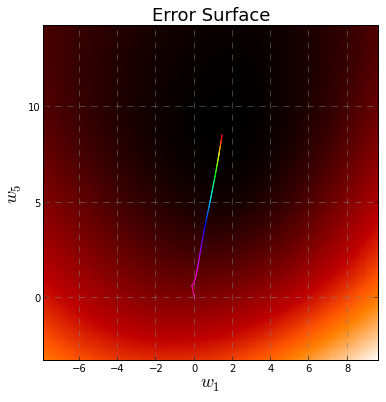

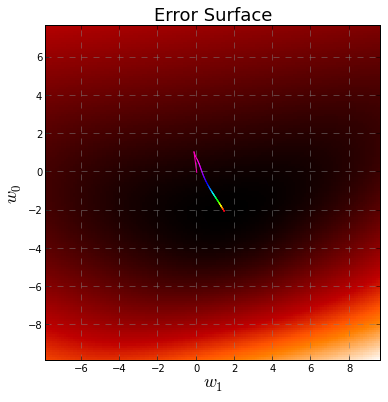

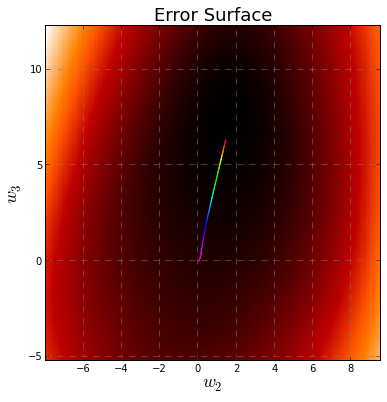

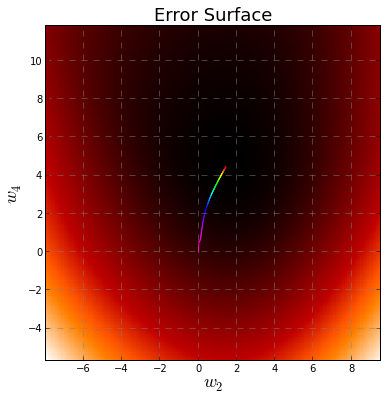

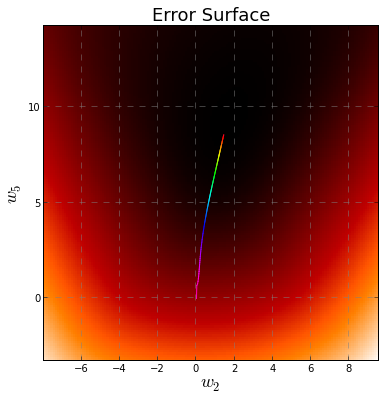

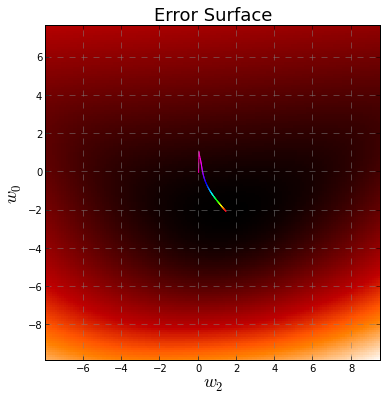

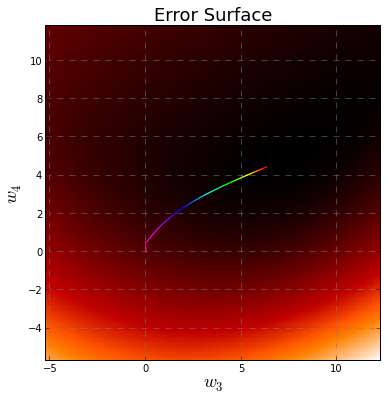

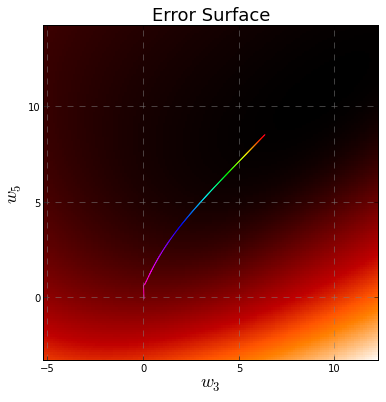

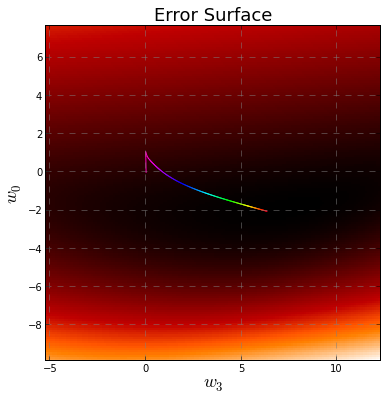

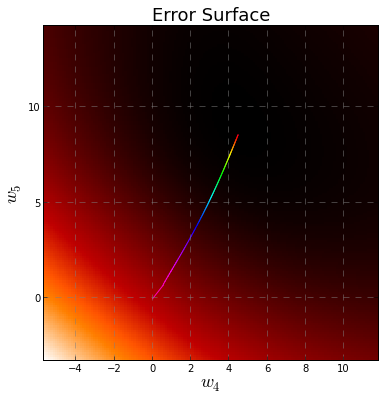

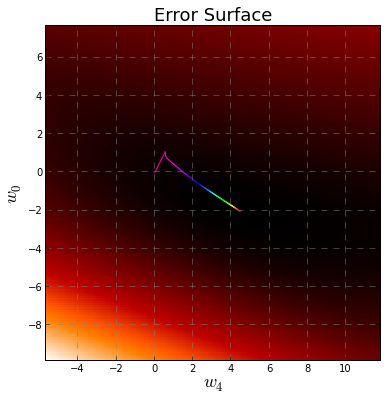

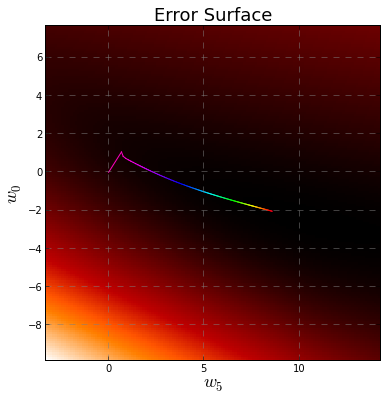

In [43]:
visualize_error_surface_slices(w_h_i, cross_entropy_error, s=150)